In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import glob
import random

이미지를 28 * 28 크기로 바꾸는 함수

In [2]:
def resize_images(img_path):
    images = glob.glob(img_path + "/*.jpg")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
    target_size = (28, 28)
    for img in images:
        old_img = Image.open(img)
        new_img = old_img.resize(target_size, Image.ANTIALIAS)
        new_img.save(img, "JPEG")

    print(f"{len(images)} 개의 이미지 크기변경")

학습 이미지들의 크기변경.
총 학습 이미지는 949개이다.

In [3]:
resize_images("C:/Users/kwansu/Desktop/AIFFEL_LMS/E_01_RockPaperScissor/data/scissor")
resize_images("C:/Users/kwansu/Desktop/AIFFEL_LMS/E_01_RockPaperScissor/data/rock")
resize_images("C:/Users/kwansu/Desktop/AIFFEL_LMS/E_01_RockPaperScissor/data/paper")

258 개의 이미지 크기변경
356 개의 이미지 크기변경
335 개의 이미지 크기변경


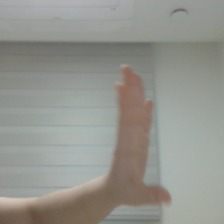

In [4]:
Image.open("C:/Users/kwansu/Desktop/AIFFEL_LMS/E_01_RockPaperScissor/data/example1.jpg")

위 이미지 처럼 사람이 보기에도 부정확하거나, 학습에 오히려 방해가 될 데이터는 모두 제거하였다.

그리고 테스트 데이터도 같은 방법으로 크기를 변경한다.
테스트 데이터는 총 300개이다.

In [5]:
resize_images("C:/Users/kwansu/Desktop/AIFFEL_LMS/E_01_RockPaperScissor/data/test/scissor")
resize_images("C:/Users/kwansu/Desktop/AIFFEL_LMS/E_01_RockPaperScissor/data/test/rock")
resize_images("C:/Users/kwansu/Desktop/AIFFEL_LMS/E_01_RockPaperScissor/data/test/paper")

100 개의 이미지 크기변경
100 개의 이미지 크기변경
100 개의 이미지 크기변경


이미지를 로드해서 데이터로 만드는 함수

기존의 이미지 개수 만큼 데이터를 만들던 것은 이미지 다양성이 부족하다고 생각되어,
기존 이미지의 좌우반전(2) * 90회전(4) * 색반전(2) = 이미지 * 16의 학습 데이터를 생성한다.

테스트 용 데이터도 이 함수로 만드는데, 굳이 테스트 데이터에 여러 작용을 거칠 필요가 없는 것 같아서
테스트용의 경우는 is_test=False인자를 True로 줄 경우 기존 이미지 개수 만큼만 만들게 하였다.

default 이미지 데이터의 최대 개수는 16000 이다. (총 이미지는 이미지수 * 16 이다.)
number_of_data=16000 인자의 개수를 변경하여 최대 개수를 변경가능하다.
그리고 생성한 이미지 데이터의 개수만큼 반환하도록 return imgs[:idx]로 변경하였다.

In [6]:
def load_data(img_path, *, number_of_data=16000, is_test = False):  # 테스트일 경우 is_test=True
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros([number_of_data, 28, 28, 3], dtype=np.int32)
    labels=np.zeros(number_of_data, dtype=np.int32)
    idx=0

    def calc_image_data(label, folder_name):
        for file in glob.iglob(img_path+f'/{folder_name}/*.jpg'):
            nonlocal idx
            img = Image.open(file)
            for _ in range(4):      # 이미지를 90도씩 회전하며 생성
                img = img.transpose(Image.ROTATE_90)
                imgs[idx,:,:,:] = np.array(img, dtype=np.int32)
                labels[idx]=label
                idx=idx+1
            
            if is_test:     # 테스트 데이터인 경우 다른 변형 처리를 넘긴다.
                continue

            img = img.transpose(Image.FLIP_LEFT_RIGHT)  # 좌우반전
            for _ in range(4):      # 이미지를 90도씩 회전하며 생성
                img = img.transpose(Image.ROTATE_90)
                imgs[idx,:,:,:] = np.array(img, dtype=np.int32)
                labels[idx]=label
                idx=idx+1

            # 색 반전
            for x in range(1 , 28):
                for y in range(1, 28):
                    img.putpixel((x,y), int(255-img.getpixel((x,y))[0]))

            for _ in range(4):      # 이미지를 90도씩 회전하며 생성
                img = img.transpose(Image.ROTATE_90)
                imgs[idx,:,:,:] = np.array(img, dtype=np.int32)
                labels[idx]=label
                idx=idx+1

            img = img.transpose(Image.FLIP_LEFT_RIGHT)  # 좌우반전
            for _ in range(4):      # 이미지를 90도씩 회전하며 생성
                img = img.transpose(Image.ROTATE_90)
                imgs[idx,:,:,:] = np.array(img, dtype=np.int32)
                labels[idx]=label
                idx=idx+1

    calc_image_data(0, 'scissor') # 각 라벨로 데이터 생성
    calc_image_data(1, 'rock')
    calc_image_data(2, 'paper')
      
    print(f"로드된 데이터의 이미지 개수는 {idx} 입니다.")
    return imgs[:idx], labels[:idx]

준비해둔 학습데이터와 테스터 데이터를 로드하고, 정규화한다.
테스터 데이터의 경우는 is_test=True로 주어 생성한다.

그리고 이전에 코드에서는 fit함수로 학습시킬 경우, 학습중간에
검증용 데이터의 accuracy를 확인하기 위해서 validation_split를 인자로 넣었다.

문제는 현재 load_data로 불러들인 데이터는 이미지의 가위, 바위, 보 순으로 읽어 들이는데,
tensorflow의 validation_split은 전체데이터에서 끝에서 데이터를 나눈 효과를 가졌다.
즉, validation_split을 사용시 보의 데이터만 떨어져 나가는 문제가 있었다. 심하면 학습용 보가 사라졌다.

그런 문제를 해결하기 위해 학습용 데이터를 suffle로 섞어주었다.
x와 y를 인덱스를 똑같이 섞어주기 위해 섞인 order리스트를 이용하였다.


마지막으로 로드된 각 입력데이를 정규화하기 위해 255로 나누었다.
x_test는 잘못 판단한 이미지 출력을 위해 x_test_normalized에 저장하였다.

In [7]:
(x_train, y_train)=load_data("C:/Users/kwansu/Desktop/AIFFEL_LMS/E_01_RockPaperScissor/data")

order = list(range(len(y_train)))     # x와 y의 인덱스를 동일하게 섞기 위한 리스트
random.shuffle(order)

x_train = x_train[order]/255.0   # 입력은 0~1 사이의 값으로 정규화
y_train = y_train[order]         # 인덱스를 섞은 order로 주어 똑같이 섞이게 만든다.

(x_test, y_test)=load_data("C:/Users/kwansu/Desktop/AIFFEL_LMS/E_01_RockPaperScissor/data/test",is_test=True)
x_test_normalized = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

로드된 데이터의 이미지 개수는 15184 입니다.
로드된 데이터의 이미지 개수는 1200 입니다.


앙상블 효과를 주기위해 모델의 생성과 학습을 함수로 만들었다.
클래스로 만들까 생각했지만, 딱히 필요성이 없어서 함수 2개로 구성하였다.

아래 함수는 모델을 생성해서 반환하는 함수이다.
모델의 구성은 각 레이어 사이에 batch normalize를 추가 하였다.

regularization효과가 있기 때문에 따로 dropout등을 하지 않아도 되고, Internal Covariate Shift문제를 해결하여 안정적인 학습이 가능하게 도와준다.

또한 하나의 컴볼루션 레이어를 추가하고, learning_rate를 입력받게 변경하였다.

In [27]:
def create_model(channels_1, channels_2, dense_output, learning_rate):
    model=tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(channels_1, (3,3), activation='relu', input_shape=(28,28,3)))
    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(channels_2, (3,3), activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(2,2))
    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(channels_2, (3,3), activation='relu'))
    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(channels_1, (3,3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))
    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(dense_output, activation='relu'))
    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(3, activation='softmax'))
    
    # learning_rate를 입력으로 받도록 변경하였다.
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

함수를 통해 생성된 모델의 구성

In [28]:
dummy_model = create_model(64,128,128, 0.001)
dummy_model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_100 (Conv2D)          (None, 26, 26, 64)        1792      
_________________________________________________________________
batch_normalization_125 (Bat (None, 26, 26, 64)        256       
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 24, 24, 128)       73856     
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 12, 12, 128)       0         
_________________________________________________________________
batch_normalization_126 (Bat (None, 12, 12, 128)       512       
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 10, 10, 128)       147584    
_________________________________________________________________
batch_normalization_127 (Bat (None, 10, 10, 128)     

기존의 fit부분을 함수로 만들었다.

validation_data로 test데이터를 넣어서 학습 도중의 결과를 나타내었다.
그리고 loss와 accurary를 그래프로 나타내었다.

In [29]:
import os

def save_model(model, path, filename, plt):
    file_path = f'{path}/{filename}'
    uniq = 1
    while os.path.exists(file_path + '.h5'):
        file_path = f'{path}/{filename}({uniq})'
        uniq += 1
        
    model.save(file_path + '.h5')
    plt.savefig(file_path + '.png')  # 나중에 확인가능하게 학습 그래프를 이미지로 같은 이름으로 저장한다.
    print(f"모델을 저장하였습니다. {file_path}'.h5'")

In [30]:
def train(model : tf.keras.Model, x_train, y_train, x_test, y_test, epochs):
    # fit과정 중의 기록인 history를 결과로 받는다.
    hist = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test,y_test))
    
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
    print(f"test_loss: {test_loss} ")
    print(f"test_accuracy: {test_accuracy}")
    
    # 기록들을 그래프로 나타낸다.
    fig = plt.figure()
    loss_ax = fig.add_subplot(2, 1, 1)
    acc_ax = fig.add_subplot(2, 1, 2)
    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    acc_ax.set_ylabel('accuray')
    loss_ax.legend(loc='upper left')
    acc_ax.legend(loc='lower left')
    
    save_path = 'C:/Users/kwansu/Desktop/AIFFEL_LMS'
    filename = f'E01_{test_accuracy:f}_{test_loss:f}' # 정확도와 오차를 이름으로 한다
    save_model(model, save_path, filename, plt)   # 학습시킨 모델을 저장한다.
    
    plt.show()

기존의 코드에서 하이퍼 파라미터로 learning_rate와 ensembles를 추가하였다.

ensembles의 수만큼 모델을 생성하고 학습시킨다.
학습시간이 너무 길어지지 않게 적당히 4개의 모델만 만들었다.


learing_rate의 경우 여러가지 실험결과 0.001일 경우 부터 테스트 데이터의 정답률이 0.99이상으로 갔다.
다만 0.001이 경우 테스트 데이터의 변동률이 커서 0.0001로 실험을 진행하자 적은 변동 폭으로
천천히 오르기는 하는데 150번의 epoch에서도 0.97정도로 학습이 너무 느렸다.
결과적으로 0.0005에서 100번에서 안정되는 학습률과 속도를 보였다.

Train on 15184 samples, validate on 1200 samples
Epoch 1/100
15184/15184 [==============================] - 4s 246us/sample - loss: 0.2621 - accuracy: 0.8994 - val_loss: 0.6156 - val_accuracy: 0.7808
Epoch 2/100
15184/15184 [==============================] - 3s 174us/sample - loss: 0.0610 - accuracy: 0.9795 - val_loss: 0.3219 - val_accuracy: 0.8867
Epoch 3/100
15184/15184 [==============================] - 3s 171us/sample - loss: 0.0403 - accuracy: 0.9866 - val_loss: 0.3149 - val_accuracy: 0.8908
Epoch 4/100
15184/15184 [==============================] - 3s 175us/sample - loss: 0.0202 - accuracy: 0.9939 - val_loss: 0.4409 - val_accuracy: 0.8825
Epoch 5/100
15184/15184 [==============================] - 3s 175us/sample - loss: 0.0285 - accuracy: 0.9911 - val_loss: 0.3256 - val_accuracy: 0.8783
Epoch 6/100
15184/15184 [==============================] - 3s 174us/sample - loss: 0.0214 - accuracy: 0.9932 - val_loss: 0.3167 - val_accuracy: 0.8875
Epoch 7/100
15184/15184 [====================

15184/15184 [==============================] - 3s 175us/sample - loss: 2.7094e-04 - accuracy: 1.0000 - val_loss: 0.0366 - val_accuracy: 0.9850
Epoch 55/100
15184/15184 [==============================] - 3s 174us/sample - loss: 0.0071 - accuracy: 0.9981 - val_loss: 0.1761 - val_accuracy: 0.9592
Epoch 56/100
15184/15184 [==============================] - 3s 175us/sample - loss: 0.0040 - accuracy: 0.9986 - val_loss: 0.0910 - val_accuracy: 0.9700
Epoch 57/100
15184/15184 [==============================] - 3s 176us/sample - loss: 0.0021 - accuracy: 0.9993 - val_loss: 0.2327 - val_accuracy: 0.9475
Epoch 58/100
15184/15184 [==============================] - 3s 176us/sample - loss: 3.5457e-04 - accuracy: 1.0000 - val_loss: 0.2534 - val_accuracy: 0.9517
Epoch 59/100
15184/15184 [==============================] - 3s 177us/sample - loss: 3.7982e-04 - accuracy: 0.9999 - val_loss: 0.2307 - val_accuracy: 0.9575
Epoch 60/100
15184/15184 [==============================] - 3s 177us/sample - loss: 1.579

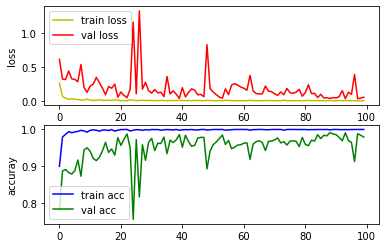

Train on 15184 samples, validate on 1200 samples
Epoch 1/100
15184/15184 [==============================] - 3s 226us/sample - loss: 0.2675 - accuracy: 0.9011 - val_loss: 0.2812 - val_accuracy: 0.8800
Epoch 2/100
15184/15184 [==============================] - 3s 176us/sample - loss: 0.0706 - accuracy: 0.9761 - val_loss: 0.6468 - val_accuracy: 0.7600
Epoch 3/100
15184/15184 [==============================] - 3s 175us/sample - loss: 0.0323 - accuracy: 0.9907 - val_loss: 0.2252 - val_accuracy: 0.9233
Epoch 4/100
15184/15184 [==============================] - 3s 174us/sample - loss: 0.0249 - accuracy: 0.9922 - val_loss: 0.1789 - val_accuracy: 0.9192
Epoch 5/100
15184/15184 [==============================] - 3s 174us/sample - loss: 0.0188 - accuracy: 0.9938 - val_loss: 0.1547 - val_accuracy: 0.9433
Epoch 6/100
15184/15184 [==============================] - 3s 179us/sample - loss: 0.0127 - accuracy: 0.9956 - val_loss: 0.2187 - val_accuracy: 0.9108
Epoch 7/100
15184/15184 [====================

15184/15184 [==============================] - 3s 188us/sample - loss: 0.0013 - accuracy: 0.9994 - val_loss: 0.0447 - val_accuracy: 0.9883
Epoch 55/100
15184/15184 [==============================] - 3s 183us/sample - loss: 5.0073e-04 - accuracy: 0.9999 - val_loss: 0.0652 - val_accuracy: 0.9775
Epoch 56/100
15184/15184 [==============================] - 3s 180us/sample - loss: 1.3860e-04 - accuracy: 1.0000 - val_loss: 0.0648 - val_accuracy: 0.9800
Epoch 57/100
15184/15184 [==============================] - 3s 182us/sample - loss: 1.0491e-04 - accuracy: 1.0000 - val_loss: 0.0507 - val_accuracy: 0.9808
Epoch 58/100
15184/15184 [==============================] - 3s 181us/sample - loss: 0.0022 - accuracy: 0.9992 - val_loss: 0.1215 - val_accuracy: 0.9625
Epoch 59/100
15184/15184 [==============================] - 3s 192us/sample - loss: 0.0032 - accuracy: 0.9989 - val_loss: 0.0413 - val_accuracy: 0.9875
Epoch 60/100
15184/15184 [==============================] - 3s 195us/sample - loss: 6.727

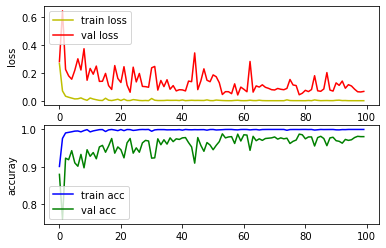

Train on 15184 samples, validate on 1200 samples
Epoch 1/100
15184/15184 [==============================] - 4s 240us/sample - loss: 0.2543 - accuracy: 0.9036 - val_loss: 0.2861 - val_accuracy: 0.8908
Epoch 2/100
15184/15184 [==============================] - 3s 186us/sample - loss: 0.0732 - accuracy: 0.9756 - val_loss: 0.1936 - val_accuracy: 0.9217
Epoch 3/100
15184/15184 [==============================] - 3s 185us/sample - loss: 0.0351 - accuracy: 0.9888 - val_loss: 0.1804 - val_accuracy: 0.9342
Epoch 4/100
15184/15184 [==============================] - 3s 186us/sample - loss: 0.0229 - accuracy: 0.9928 - val_loss: 0.3099 - val_accuracy: 0.8775
Epoch 5/100
15184/15184 [==============================] - 3s 191us/sample - loss: 0.0258 - accuracy: 0.9922 - val_loss: 0.1612 - val_accuracy: 0.9317
Epoch 6/100
15184/15184 [==============================] - 3s 191us/sample - loss: 0.0228 - accuracy: 0.9928 - val_loss: 0.2292 - val_accuracy: 0.9208
Epoch 7/100
15184/15184 [====================

15184/15184 [==============================] - 3s 170us/sample - loss: 1.4235e-04 - accuracy: 1.0000 - val_loss: 0.2750 - val_accuracy: 0.9308
Epoch 55/100
15184/15184 [==============================] - 3s 171us/sample - loss: 0.0029 - accuracy: 0.9993 - val_loss: 0.1184 - val_accuracy: 0.9600
Epoch 56/100
15184/15184 [==============================] - 3s 198us/sample - loss: 0.0011 - accuracy: 0.9997 - val_loss: 0.0948 - val_accuracy: 0.9650
Epoch 57/100
15184/15184 [==============================] - 3s 184us/sample - loss: 3.2625e-04 - accuracy: 1.0000 - val_loss: 0.1265 - val_accuracy: 0.9550
Epoch 58/100
15184/15184 [==============================] - 3s 179us/sample - loss: 1.1971e-04 - accuracy: 1.0000 - val_loss: 0.0751 - val_accuracy: 0.9683
Epoch 59/100
15184/15184 [==============================] - 3s 180us/sample - loss: 0.0032 - accuracy: 0.9990 - val_loss: 0.1331 - val_accuracy: 0.9608
Epoch 60/100
15184/15184 [==============================] - 3s 181us/sample - loss: 0.003

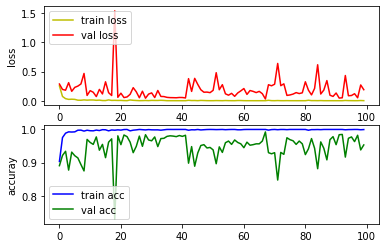

Train on 15184 samples, validate on 1200 samples
Epoch 1/100
15184/15184 [==============================] - 4s 242us/sample - loss: 0.2411 - accuracy: 0.9067 - val_loss: 0.6166 - val_accuracy: 0.7858
Epoch 2/100
15184/15184 [==============================] - 3s 177us/sample - loss: 0.0606 - accuracy: 0.9796 - val_loss: 0.6900 - val_accuracy: 0.7892
Epoch 3/100
15184/15184 [==============================] - 3s 178us/sample - loss: 0.0339 - accuracy: 0.9898 - val_loss: 0.2367 - val_accuracy: 0.9317
Epoch 4/100
15184/15184 [==============================] - 3s 177us/sample - loss: 0.0168 - accuracy: 0.9953 - val_loss: 0.2543 - val_accuracy: 0.9033
Epoch 5/100
15184/15184 [==============================] - 3s 175us/sample - loss: 0.0236 - accuracy: 0.9919 - val_loss: 0.1973 - val_accuracy: 0.9375
Epoch 6/100
15184/15184 [==============================] - 3s 180us/sample - loss: 0.0124 - accuracy: 0.9963 - val_loss: 0.7402 - val_accuracy: 0.8242
Epoch 7/100
15184/15184 [====================

15184/15184 [==============================] - 3s 191us/sample - loss: 7.6963e-04 - accuracy: 0.9998 - val_loss: 0.2455 - val_accuracy: 0.9433
Epoch 55/100
15184/15184 [==============================] - 3s 182us/sample - loss: 0.0076 - accuracy: 0.9979 - val_loss: 0.1753 - val_accuracy: 0.9558
Epoch 56/100
15184/15184 [==============================] - 3s 177us/sample - loss: 7.3234e-04 - accuracy: 0.9997 - val_loss: 0.1149 - val_accuracy: 0.9683
Epoch 57/100
15184/15184 [==============================] - 3s 177us/sample - loss: 2.9700e-04 - accuracy: 0.9999 - val_loss: 0.1464 - val_accuracy: 0.9575
Epoch 58/100
15184/15184 [==============================] - 3s 178us/sample - loss: 1.1400e-04 - accuracy: 1.0000 - val_loss: 0.1181 - val_accuracy: 0.9733
Epoch 59/100
15184/15184 [==============================] - 3s 180us/sample - loss: 7.6596e-05 - accuracy: 1.0000 - val_loss: 0.0939 - val_accuracy: 0.9725
Epoch 60/100
15184/15184 [==============================] - 3s 182us/sample - los

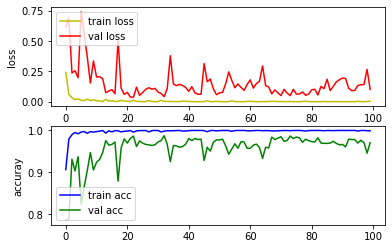

In [31]:
n_train_epoch = 100
n_channel_1 = 64
n_channel_2 = 128
n_dense = 128
learning_rate = 0.0005
ensembles = 4

# 앙상블을 할 수만큼 모델들을 생성한다.
models = [create_model(n_channel_1, n_channel_2, n_dense,
                       learning_rate) for _ in range(ensembles)]
                       
for model in models:  # 각 모델들을 학습 시킨다.
    train(model, x_train, y_train, x_test_normalized, y_test, n_train_epoch)

앙상블의 효과를 보기 위해 tensorflow.keras.Model의 predict함수 대신 직접 accuracy를 구하였다.


In [38]:
save_path = 'C:/Users/kwansu/Desktop/AIFFEL_LMS'

loaded_models = [tf.keras.models.load_model(file) for file in glob.iglob(save_path+'/*.h5')]
print(f"{len(loaded_models)} 개의 모델을 불러왔습니다.")

4 개의 모델을 불러왔습니다.


In [39]:
predictions = [model.predict(x_test_normalized) for model in loaded_models]
predictions = np.sum(predictions, axis=0) / ensembles

ensemble_correct_prediction = np.equal(np.argmax(predictions, 1), y_test)
print(f"Ensemble accuracy: {np.mean(ensemble_correct_prediction)}")

ERROR! Session/line number was not unique in database. History logging moved to new session 154
Ensemble accuracy: 0.9941666666666666


최종 결과는 0.9958이 나왔다.
여러번 실험 결과 0.989~0.998사이를 왔다갔다 하였다.

잘못 평가된 데이터를 모아보았다.

잘못 평가한 이미지 개수 : 7


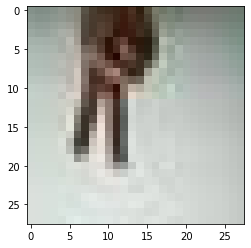

확률평가 (가위:0.474578),(바위:0.000000),(보:0.525422)


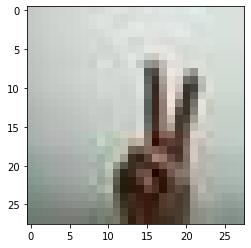

확률평가 (가위:0.450930),(바위:0.000000),(보:0.549070)


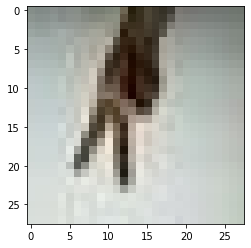

확률평가 (가위:0.397672),(바위:0.122038),(보:0.480290)


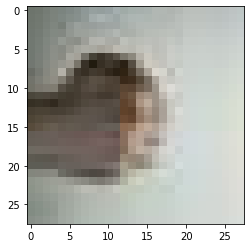

확률평가 (가위:0.497233),(바위:0.486378),(보:0.016389)


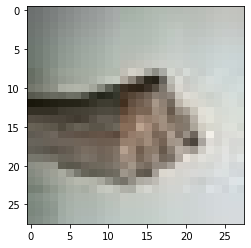

확률평가 (가위:0.000087),(바위:0.462268),(보:0.537644)


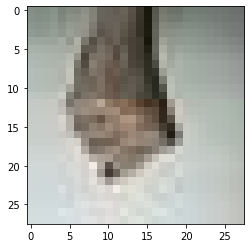

확률평가 (가위:0.000000),(바위:0.458096),(보:0.541904)


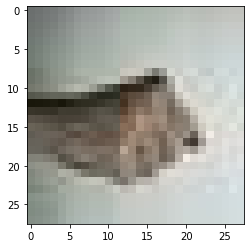

확률평가 (가위:0.000000),(바위:0.317400),(보:0.682600)


In [40]:
wrong_indices = np.where(ensemble_correct_prediction == 0)[0]
print(f"잘못 평가한 이미지 개수 : {len(wrong_indices)}")

for i in wrong_indices:
    plt.imshow(x_test[i])
    plt.show()
    print(f"확률평가 (가위:{predictions[i,0]:f}),(바위:{predictions[i,1]:f}),(보:{predictions[i,2]:f})")

틀린 내용을 자세히 보면 가위와 보의 경우, 0.01퍼의 확률차이로 잘못 판단한 것으로 나온다.
그리고 주먹이 크게 나온 사진의 경우는 보와 바위가 비슷한 확률로 나온다.

특히 바위의 경우는 손등이 나온 경우 손가락이 안보여서 붙여진 보와 구분이 힘든 것으로 생각된다.

이 부분은 픽셀이 줄어들면서 구분하기 힘들어 진 부분도 있다고 예상된다.

### 총평

가위, 바위, 보 이미지를 인식하는 모델을 만들어보았다.
초기의 스스로 찍은 300개(100 * 3) 이미지로 학습한 경우 같은 환경(스스로 찍은)에서는
테스트데이터를 전혀 학습에 영향을 주지 않아도 1.0이 나왔었다.

문제는 다른 환경(다른 사람이 찍은 이미지)에서는 정답률이 매우 떨어졌다.
당연히 스스로 찍은 하나의 환경에서 학습한 데이터이기 때문이다.

그래서 여러 사람들이 올린 이미지를 모아서 학습을 시키고, 또 다른 사람의 이미지로
테스트를 했지만, 여전히 성능이 좋지않았다.

전체적으로 학습데이터의 부족과 잘못된 학습 데이터가 있다는 문제가 생각되었다.

우선적으로 사람이 보기에도 애매한 이미지(잔상, 보를 옆면으로 일자로 편 경우등)를
제거하여, 확실히 구분 가능한 학습데이터들만 남겼고, 너무 배경이 화려해서 손에 이미지가
구분이 안가는 경우도 제외시켰다.

그 다음으로는 너무 단일 방향인 손 이미지들을 좌우반전과 회전을 통해 다양한 이미지를 얻었다.
거기에 환경마다 색이 다를 수 있고, 실제로 가위/바위/보의 경우 색이 중요하지 않다고 판단하여,
색을 반전시켜서 학습시켰다.

확실히 위의 이미지의 다양성을 늘리니깐 0.9이상으로 accuracy가 늘었다.
거기에 많은 epohc에서 테스트 정답률이 떨어지는 overfit을 막기 위해 batch normalization을 사용하였다.
추가적으로 마지막 애매하게 안오르는 accuracy를 올리기 위해 ensemble을 사용하여,
최종적으로 0.995 accuracy를 얻게되었다.

개인적으로 좀더 화질을 올리거나 다양한(대신 확실히 분류가능한) 데이터가 있으면,
좀 더 범용적인 인식기를 만들 수 있을 것 같다는 생각이 들었다.